In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
#from scipy.optimize import curve_fit
from scipy import signal
from skimage import io
import os
from skimage import data

# Import Data and Correct for Background Counts

(252, 512, 512)
(26, 512, 512)


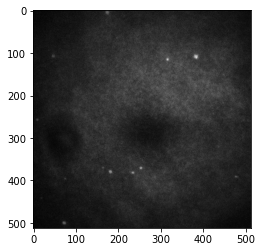

In [3]:
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP\FRAP notebook for Markus')
#First import the meta data as md

meta_data_filename= 'well3_slide2_561nm_OD1p6_SNAP(3)-TMR_0p5mgmL_Epi_2_MMStack_Pos0_metadata.txt'
md = pd.read_json(meta_data_filename) 

# Now import the background files- just a POPC bilayer that has had no dye added
os.chdir(r'background')

filename_bg = 'well9_561nm_OD2_POPC(c)_1\well9_561nm_OD2_POPC(c)_1_MMStack_Pos0.ome.tif'
bg = io.imread(filename_bg)

filename_bg2 = 'well10_561nm_OD2_POPC(c)_1\well10_561nm_OD2_POPC(c)_1_MMStack_Pos0.ome.tif'
bg2 = io.imread(filename_bg2)

background = np.mean(np.concatenate((bg,bg2))) # find the average background counts- 
background= background.astype(float) # Convert to a float

# We have manually split the data into pre and post bleach videos import both seperately
os.chdir(os.path.dirname(os.getcwd())) # Go up one from the cwd
filename_post = 'post\post_well3_slide2_561nm_OD1p6_SNAP(3)-TMR_0p5mgmL_Epi_2_MMStack_Pos0.ome.tif'
filename_pre = 'pre\pre_well3_slide2_561nm_OD1p6_SNAP(3)-TMR_0p5mgmL_Epi_2_MMStack_Pos0.ome.tif'

im_post = io.imread(filename_post)
im_pre = io.imread(filename_pre)
im_post = im_post.astype(float) #Convert the entries in each array to floats
im_pre = im_pre.astype(float) #Convert the entries in each array to floats

im_post = im_post-background #Correct for bg counts
im_pre = im_pre-background #Correct for bg counts

print(np.shape(im_post))
print(np.shape(im_pre))
# Visualise the image 
fig, ax= plt.subplots()
ax.imshow(im_post[0],cmap=plt.cm.gray)
plt.show()

# Correct for uneven illumination

First take the mean of the pre bleach images

In [4]:
mean_pre = np.empty((512,512))  #create an empty array for the averaged pre image
for j in range(len(im_pre[1])): #Iterate over all rows
    for i in range(len(im_pre[2])): #Iterate over all columns
        mean_pre[i][j] = np.mean(im_pre[:,i,j]) #Calculate the average of each pixel and set the value of the mean_pre array

Divide all the images post and pre bleach by the pre bleach average (normalise the data to the pre-bleach images)

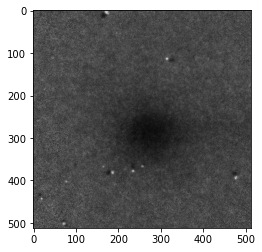

In [5]:
for i in range(len(im_post[:,0,0])): # Divide all images after the bleach by the pre bleach average
    im_post[i]= im_post[i]/mean_pre
    
    
for i in range(len(im_pre[:,0,0])): # Divide all images before the bleach by the pre bleach average- just do this for completeness
    im_pre[i]= im_pre[i]/mean_pre

    
# Plot to visulaise the correction for uneven illumination
fig, ax= plt.subplots()
ax.imshow(im_post[2],cmap=plt.cm.gray)
plt.show()

# Find temporal fluctuations function from reference area

### Take the pre from the post to find the bleached spot


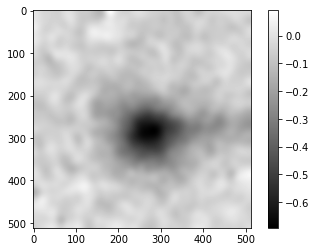

In [6]:
spot = im_post[0]-im_pre[-1] #take the last image from pre from the first image post- only left with the spot (negative values)
spot= gaussian_filter(spot,sigma=10) #gaussian blur
fig, ax= plt.subplots()
plot= ax.imshow(spot,cmap=plt.cm.gray)
fig.colorbar(plot)
plt.show()

In [ ]:
limit = np.mean(spot) #set a thershold of all values a over the mean value, spot= (first postbleach-last pre bleach), in this case all values over -0.1 are defined as in the reference area

# Only find the reference area once
reference_df= pd.DataFrame(data=np.empty((512, 2)),columns={'Col', 'Ave_Col'},dtype=object) # Create an empty df
for i in range(512):
        reference_index = [idx for idx, val in enumerate(spot[i,:]) if val > limit] #Get index of values that are above the limit(mean)
        reference_df.loc[i,'Col'] = reference_index
reference_df=reference_df[reference_df['Col'].map(lambda d: len(d)) > 0] #Remove empty lists- should'nt be any in this case

temporal_array= np.empty((1,len(im_post))) #Create an array to put the temporal change data in

for j in range(len(im_post)):
    ## Calculate the average intensity at each 
    ref_array= np.empty((1,512))
    for i in range(len(reference_df['Col'])): #Iterate over all the rows
        ref_array[:,i]= np.mean(im_post[j][reference_df.index[i]]) #Calculate the mean at each row for each column
    ave_ref_int =  np.mean(ref_array)# calculate the mean at each column (all the reference pixels)
    temporal_array[:,j]= ave_ref_int
    print(j, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 

# Fit an exponential decay to the temporal changes

In [2]:
x=np.array([i for i in range(len(im_post))])
def func(x,a,b):
    return (a*(np.exp(-x/b)))
popt, pcov = curve_fit(func, x, temporal_array[0,:], maxfev=100000000)#, p0=[13000,4000000,-1300])#, method='lm')
print(popt)
print(pcov)
perr_sd = np.sqrt(np.diag(pcov))
print(perr_sd)

NameError: name 'im_post' is not defined

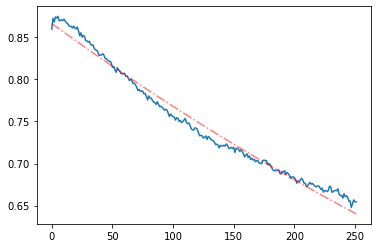

In [9]:
a, b = popt
fig, ax= plt.subplots()
ax.plot(x,temporal_array[0,:])
ax.plot(x, func(x,*popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')

# Correct data for temporal variations- 'photofading'

In [10]:
for i in range(len(im_post[:,0,0])): # Divide all images after bleach by function which gives the amount photofaded
    im_post[i]= im_post[i]/func(i,a,b)

# Fit a 2D exponential of a gaussian to the images

$$ e^{\frac{2(x^{2}+y^{2})}{{r_{e}}^2}} $$

It will take a while (~10-15 mins) to fit to all of the data, therefore to change to a smaller number of frames simply change the 'frames' variable at the top of the next cell.

In [11]:
frames = 50 #currently set to analyse the first 50 frames of the data, if want all data change to 'len(im_post)'

def expguass(VARS,x0,y0,depth,Re):
    X,Y= VARS
    return np.exp(-depth*np.exp((-2*((X-x0)**2+(Y-y0)**2))/(Re**2))) #Define the expnonential gaussain


df= pd.DataFrame(columns=['x0', 'y0', 'Depth', 'Re','Intensity at Re=sd','Time (s)'],index=np.arange(frames)) #Create a df to put the fittted parameters in

x,y = np.arange(0, 512), np.arange(0, 512) #Define the x and y grid for fitting- as a 2D function need to use meshgrid and later ravel
X, Y = np.meshgrid(x, y)

xdata = np.vstack((X.ravel(), Y.ravel())) # Define xdata for fitting (really x and y data)
for i in range(frames): # Perform fitting over however many images you need
    Z= im_post[i] #Define the Z data as your image data
    
    popt,pcov = curve_fit(expguass,xdata,Z.ravel(),p0=[256,256,1,1],maxfev = 100000) #Perform fit 
    x0,y0,depth,Re= popt
    
    perr_sd = np.sqrt(np.diag(pcov)) #Calculate the error on the fit
    df.iloc[i] = {'x0': x0, 'y0': y0,'Depth':depth,'Re':Re} #Place the values in the df
    print(i, end=' ')
    
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Find the intensity of the fitted function at a width of a standard deviation

In [12]:
df['Intensity at Re=sd'] = np.exp(-(df['Depth'].astype(float))*(np.exp(-2)))

Get the times at each frame- originally each video was 300 frames long, however when splitting into pre and post bleach videos the frames in which bleaching occured were removed. Additionally, we want 'time 0' to be at the first post bleach frame as opposed to the pre bleach frames

In [13]:
bleaching_frames = 300-len(im_pre)-len(im_post) # Find the number of frames which were removed when split into pre and post bleach
#Want to start the timer count at the start of im_post (1+to remove column title)
times = (((md.loc['ElapsedTime-ms'][1+bleaching_frames+len(im_pre):]- md.loc['ElapsedTime-ms'][1+bleaching_frames+len(im_pre)])/1000).to_numpy())# From the metadata get the time values after the pre and bleaching frames. Then subtract the inital value so the first frame is set to 0  
df['Time (s)'] = times[:frames]

Some problems to note here- mainly you can see from values of Re that the bleached spot expands over time significantly; we should question if this makes the analysis valid. Alternatively we could have simply fitted the gaussian to the first frame, found a value for Re then followed recovery at this radius, but this additionally seems wrong. Need to think about how to deal with this formally. Note- this also occurs with simulated COMSOL data.

In [19]:
print('Size of Re at start = '+str(df['Re'][0])) # In units of 'pixels' here
print('Size of Re at frame 50 = '+str(df['Re'][49]))

Size of Re at start = 94.98239683579408
Size of Re at frame 50 = 146.14220749446167


Plot the 2D gaussian

C:\Users\tselb\AppData\Local\Temp/ipykernel_15204/1959636451.py:13: UserWarning: The following kwargs were not used by contour: 'zlim'
  fitted_exp_gauss_contor= ax0.contour(X,Y,Z,cmap=cmap,zlim=(0,1))
C:\Users\tselb\AppData\Local\Temp/ipykernel_15204/1959636451.py:14: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = fig.colorbar(fitted_exp_gauss_contor,location='left')


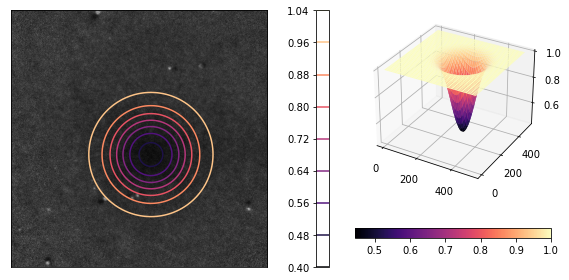

In [30]:
n=5 # gives the frame number you want 
cmap = 'magma'

X,Y= np.meshgrid(x,y) # Need to create a meshgrid for x&y
Z=np.exp(-df['Depth'][n]*np.exp((-2*((X-df['x0'][n])**2+(Y-df['y0'][n])**2))/(df['Re'][n]**2))) # Define Z based off the optimal parameters determined from the curve fitting


fig= plt.figure(figsize=plt.figaspect(0.5))
ax0,ax1= fig.add_subplot(1, 2, 1),fig.add_subplot(1, 2, 2, projection='3d')
ax0.imshow(im_post[n],cmap=plt.cm.gray)
ax0.set_xticks([])
ax0.set_yticks([])
fitted_exp_gauss_contor= ax0.contour(X,Y,Z,cmap=cmap,zlim=(0,1))
cb = fig.colorbar(fitted_exp_gauss_contor,location='left')
fitted_exp_gauss_3d = ax1.plot_surface(X,Y,Z,cmap=cmap,label='Model') 
fig.colorbar(fitted_exp_gauss_3d,location='bottom')
plt.tight_layout()
plt.show()

# Use an exponential model to estimate the immobile fraction

Use a very large number with the model to estimate F(inf)- this may not be the best way of estimating immobile fraction however I couldn't think of a better one, at the time maybe jut using it as a parameter to be fitted in the taylor expansion later would be a better way of doing it.

$$ M_{f} = \frac{F_{\infty}-F_{0}}{F_{i}-F_{0}} $$

0.7331044801845727


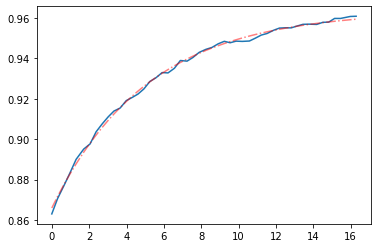

In [33]:
def recovery(x,a,b,c):
    return a*(1-np.exp(-x/b))+c

df = df.drop(df.index[df['Intensity at Re=sd'] == np.inf].tolist(),axis=0) # Need to remove data that contains 'inf' from bad fitting
df = df.drop(df.index[df['Intensity at Re=sd'] == np.nan].tolist(),axis=0) # Similarly get rid of fitting that contains 'NaNs'
time=df['Time (s)'].to_numpy(dtype=float)
Int =df['Intensity at Re=sd'].to_numpy(dtype=float)
popt, pcov = curve_fit(recovery, time, Int, maxfev=10000, p0=[0.08,4,0.7])
a, b, c = popt

Fi= 1 # Intensity at the start before bleaching~ 1 as normalised
F0= min(df['Intensity at Re=sd'])# The initial bleach depth
Finf=a*(1-np.exp(-999999999999/b))+c #Just use a very large number for Finf
frac_mobile = (Finf-F0)/(Fi-F0)


print(frac_mobile)
fig, ax = plt.subplots()
ax.plot(time,Int)
ax.plot(time,recovery(time, *popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')
plt.show()

# Perform Taylor expansion and find Diff coeff

$$ F(t) = \sum\limits_{n=0}^\infty\frac{(-K)^{n}}{n!(1+n(1+\frac{2t}{\tau}))}M_{f} + (1-M_{f})F_{0} $$


$$ D = \frac{r_{e}^{2}}{4\tau} $$

Values for K and Td= 0.33959451554316 2.031572665188381
And their respective errors- found from taking the squareroot of the diagonals of the covarience matrix achived from the fit= [0.01553255 0.17182233]


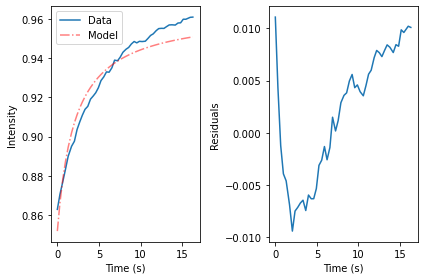

12.601415734959748  microm2/s


In [37]:
def texpansion(t,K,Td):
    total = float(0)
    for n in range(100): #gives the number of terms you want in your expansion, currently set to 100- anything over this you may run into problems with calculating large numbers from the factoria
        total = total + (frac_mobile*((-K)**n)/((np.math.factorial(n))*(1+n*(1+(2*t/Td)))))  #Add up all the terms in the serise expansion
    return total + (1-frac_mobile)*F0 #return the sum

popt,pcov = curve_fit(texpansion,df['Time (s)'],df['Intensity at Re=sd'],p0=[0.3,2],maxfev=10000) #optimse for the sum of the t expansion
K, Td = popt 
perr = np.sqrt(np.diag(pcov)) # Find the error on the fitting form the square root of the diagonals of the covariance matrix
print('Values for K and Td=',K,Td)
print('And their respective errors- found from taking the squareroot of the diagonals of the covarience matrix achived from the fit=',perr)

# Calculate the residuals- Simply the difference from the model to the data at each point
res = df['Intensity at Re=sd'] - texpansion(df['Time (s)'], *popt)


fig, ax = plt.subplots(1,2)
ax[0].plot(df['Time (s)'],df['Intensity at Re=sd'],label='Data')
ax[0].plot(df['Time (s)'], texpansion(df['Time (s)'],*popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')
ax[0].legend()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Intensity')
ax[1].plot(df['Time (s)'],res)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

pixel_length = (16/150) #(in um) up until now Re has been in length of pixels so we need to convert it to um
w= (min(df['Re'][0:20]))*pixel_length
D=(w**2)/(4*Td)
print(str(D)+'  microm2/s')

The fitting doesn't look great here, but gets better if you include more than just 50 frames